### Standard LR Model with feature engineered data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lime.lime_tabular
import shap
from IPython.display import display, HTML

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = '/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_engineered_data.csv'
GROUP_COLS = ['State Code', 'County Code', 'Site Num']
TARGET = 'DailyAQI'

# Base + Engineered Features (same as LSTM)
BASE_FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25', 'BarometricPressure', 'Temperature', 'WindResultant']
ENG_FEATURES = [
    'AQI_lag_1','AQI_lag_3','AQI_lag_7',
    'AQI_roll_3','AQI_roll_7',
    'CO_roll_3','CO_roll_7','NO2_roll_3','NO2_roll_7','PM25_roll_3','PM25_roll_7','O3_roll_3','O3_roll_7',
    'month','dayofweek','is_weekend','dayofyear',
    'PM25xTemp','NO2xWind'
]
FEATURES = BASE_FEATURES + ENG_FEATURES

In [3]:
df = pd.read_csv(DATA_PATH)
df['Date Local'] = pd.to_datetime(df['Date Local'])

# Drop rows missing required columns
df = df.dropna(subset=FEATURES + [TARGET]).copy()

df = df.sort_values('Date Local').reset_index(drop=True)
dates_sorted = df['Date Local'].values
cut1 = np.quantile(dates_sorted, 0.70)
cut2 = np.quantile(dates_sorted, 0.80)

train_df = df[df['Date Local'] <= cut1]
val_df   = df[(df['Date Local'] > cut1) & (df['Date Local'] <= cut2)]
test_df  = df[df['Date Local'] > cut2]

print(f"Train/Val/Test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Val/Test sizes: 64291, 9124, 18325


In [4]:
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

In [5]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))   # alpha can be tuned if needed
])

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [6]:
y_pred = lr_pipe.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-6))) * 100
r2   = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")

MSE: 34.560 | RMSE: 5.879 | MAE: 3.309 | MAPE: 126937.28% | R²: 0.956


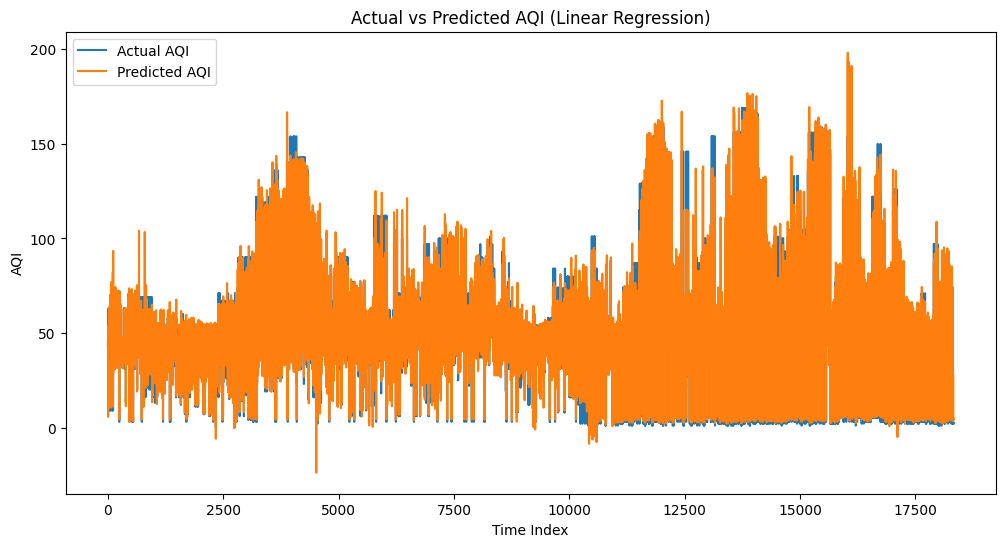

In [7]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Linear Regression)')
plt.xlabel('Time Index'); plt.ylabel('AQI'); plt.legend(); plt.show()

In [8]:
ridge_model = lr_pipe.named_steps['ridge']
coef_df = pd.DataFrame({'Feature': FEATURES, 'Coefficient': ridge_model.coef_})
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print("\nTop Feature Coefficients:")
print(coef_df.head(15))


Top Feature Coefficients:
        Feature  Coefficient
11   AQI_roll_3    63.351140
8     AQI_lag_1   -23.471550
17  PM25_roll_3   -15.582584
4          PM25    13.067593
9     AQI_lag_3   -11.692118
19    O3_roll_3    -6.272045
3            O3     5.199846
12   AQI_roll_7     4.429663
18  PM25_roll_7     2.061936
10    AQI_lag_7    -1.352336
15   NO2_roll_3    -1.314127
2           NO2     1.199875
25    PM25xTemp     1.131196
20    O3_roll_7     1.129707
0            CO    -0.850449


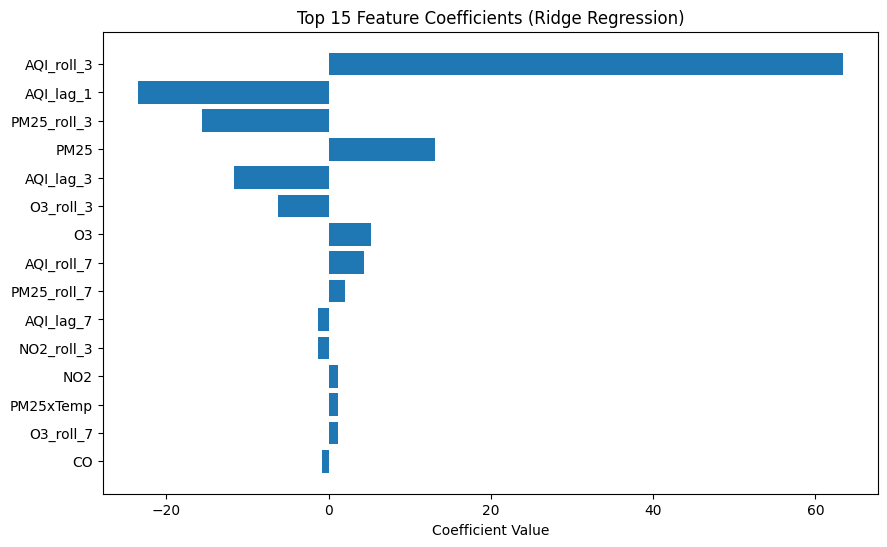

In [9]:
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'][:15], coef_df['Coefficient'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Coefficients (Ridge Regression)")
plt.xlabel("Coefficient Value")
plt.show()

In [10]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=FEATURES,
    mode='regression'
)

i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test.values[i],
    predict_fn=lr_pipe.predict,
    num_features=10
)

try:
    exp.show_in_notebook(show_table=True)
except Exception:
    display(HTML(exp.as_html()))

with open("exp9_lime_explanation.html", "w") as f:
    f.write(exp.as_html())

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/var/folders/rx/gyp8p3vs42zfzk_hwhrnpcmw0000gn/T/ipykernel_54846/3702240499.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:200], feature_names=FEATURES)


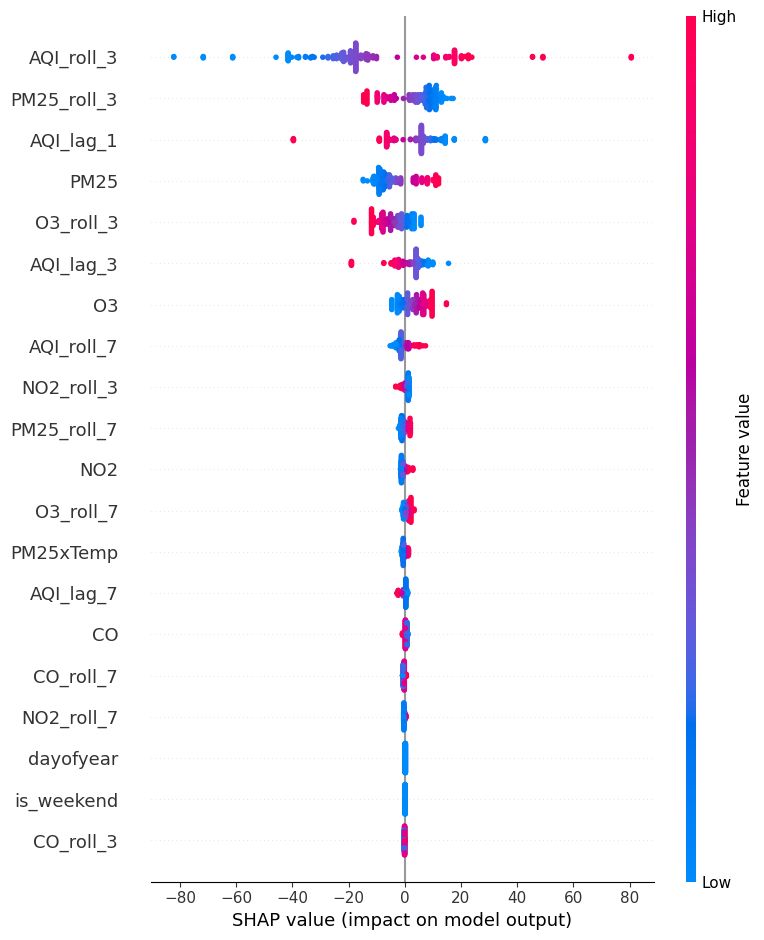

In [11]:
explainer = shap.Explainer(lr_pipe.predict, X_train)
shap_values = explainer(X_test[:200])

shap.summary_plot(shap_values, X_test[:200], feature_names=FEATURES)